In [ ]:
#AIT 736 Final Project

In [1]:
# 1. Imports & Reproducibility
import numpy as np
import random
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer, Conv2D, MaxPooling2D,
    Dropout, Flatten, Dense, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Theme name (you can print this in slides / notebook)
THEME_NAME = "Inferno Spectrum Digits: Visualizing Handwriting Intensity"
print("Visual Theme:", THEME_NAME)

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Visual Theme: Inferno Spectrum Digits: Visualizing Handwriting Intensity
TensorFlow version: 2.19.0
Num GPUs Available: 1


In [5]:
# 2. Loading MNIST & Basic Info
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Original train shape:", x_train.shape)
print("Original test shape :", x_test.shape)
print("Unique labels:", np.unique(y_train))

Original train shape: (60000, 28, 28)
Original test shape : (10000, 28, 28)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


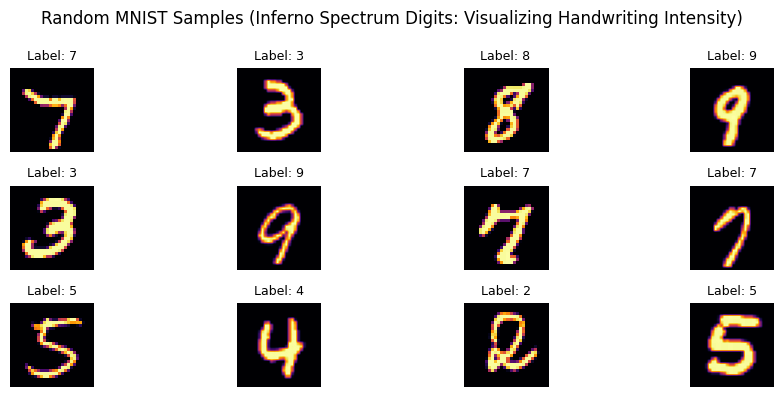

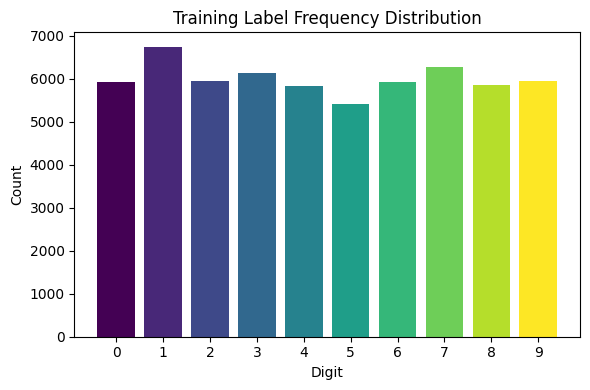

In [6]:
# 3. Simple EDA – Sample Images & Label Distribution
# Showing a few random digits with the "inferno" theme
num_samples = 12
idx = np.random.choice(len(x_train), num_samples, replace=False)

plt.figure(figsize=(10, 4))
for i, id_ in enumerate(idx):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_train[id_], cmap='inferno')
    plt.title(f"Label: {y_train[id_]}", fontsize=9)
    plt.axis('off')
plt.suptitle("Random MNIST Samples (" + THEME_NAME + ")", fontsize=12)
plt.tight_layout()
plt.show()

# Labeling distribution with viridis gradient
counts = np.bincount(y_train)
plt.figure(figsize=(6, 4))
colors = plt.cm.viridis(np.linspace(0, 1, 10))
plt.bar(range(10), counts, color=colors)
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("Training Label Frequency Distribution")
plt.xticks(range(10))
plt.tight_layout()
plt.show()

In [7]:
# 4. Preprocessing – Normalize, Reshape, One-hot, Split
# Scaling pixels to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# Reshaping to (28, 28, 1) for CNN
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

print("After reshape, train:", x_train.shape)
print("After reshape, test :", x_test.shape)

# One-hot encode test labels (keep train/val flexible)
y_test_cat = to_categorical(y_test, num_classes=10)

# Train/validation split (10% for validation)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

y_train_cat = to_categorical(y_train, num_classes=10)
y_val_cat   = to_categorical(y_val,   num_classes=10)

print("Train:", x_train.shape, y_train.shape)
print("Val  :", x_val.shape,   y_val.shape)
print("Test :", x_test.shape,  y_test.shape)

After reshape, train: (60000, 28, 28, 1)
After reshape, test : (10000, 28, 28, 1)
Train: (54000, 28, 28, 1) (54000,)
Val  : (6000, 28, 28, 1) (6000,)
Test : (10000, 28, 28, 1) (10000,)


In [8]:
#5. Data Augmentation (ImageDataGenerator)
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

batch_size = 128

train_gen = train_datagen.flow(x_train, y_train_cat, batch_size=batch_size)
val_gen   = val_datagen.flow(x_val,   y_val_cat,   batch_size=batch_size)


In [9]:
# 6. CNN Model Definition
#    (Conv → BatchNorm → Pool → Dropout → Dense)
def build_cnn(dropout_rate=0.35):
    model = Sequential([
        InputLayer(input_shape=(28, 28, 1)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    return model

model = build_cnn(dropout_rate=0.35)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 468,202 (1.79 MB)

 Trainable params: 468,010 (1.79 MB)

 Non-trainable params: 192 (768.00 B)

In [10]:
# 7. Compile Model + Callbacks & Hyperparameters
initial_lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

In [13]:
# 8. Training – with timing (for efficiency discussion)
epochs = 10

start_time = time.time()
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
train_time = time.time() - start_time
print(f"\nTotal training time: {train_time:.2f} seconds")

Epoch 1/10
422/422 - 18s - 41ms/step - accuracy: 0.9878 - loss: 0.0441 - val_accuracy: 0.9928 - val_loss: 0.0242 - learning_rate: 2.5000e-04
Epoch 2/10
422/422 - 16s - 39ms/step - accuracy: 0.9882 - loss: 0.0416 - val_accuracy: 0.9942 - val_loss: 0.0191 - learning_rate: 2.5000e-04
Epoch 3/10
422/422 - 17s - 40ms/step - accuracy: 0.9884 - loss: 0.0406 - val_accuracy: 0.9933 - val_loss: 0.0200 - learning_rate: 2.5000e-04
Epoch 4/10

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
422/422 - 20s - 47ms/step - accuracy: 0.9887 - loss: 0.0382 - val_accuracy: 0.9947 - val_loss: 0.0191 - learning_rate: 2.5000e-04
Epoch 5/10
422/422 - 17s - 40ms/step - accuracy: 0.9898 - loss: 0.0350 - val_accuracy: 0.9940 - val_loss: 0.0204 - learning_rate: 1.2500e-04
Epoch 6/10

Epoch 6: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
422/422 - 17s - 39ms/step - accuracy: 0.9902 - loss: 0.0326 - val_accuracy: 0.9945 - val_loss: 0.0201 - learning_rate: 1.2500e-04
E

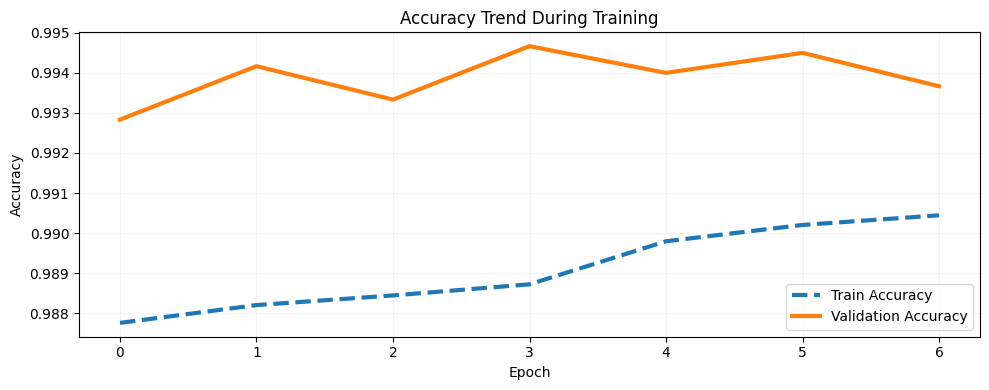

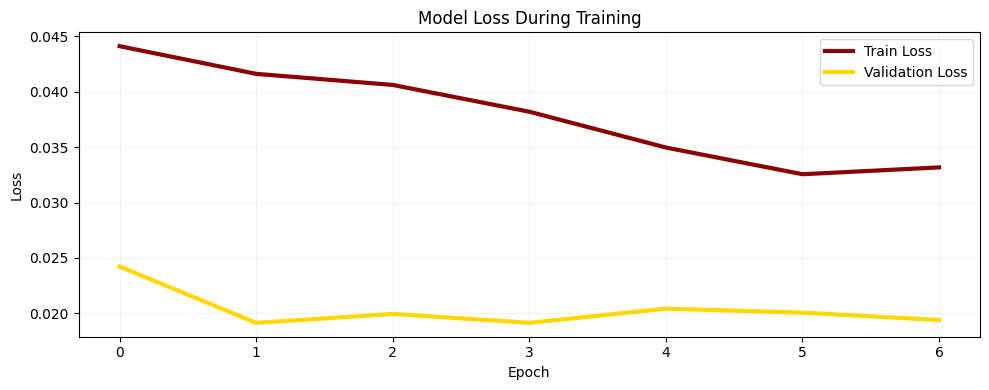

In [14]:
# 9. Plot Accuracy & Loss Curves (Custom Style)
def plot_history(h):
    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.plot(h.history['accuracy'], linewidth=3, linestyle='--', label='Train Accuracy')
    plt.plot(h.history['val_accuracy'], linewidth=3, linestyle='-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Trend During Training')
    plt.legend()
    plt.grid(alpha=0.15)
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(10, 4))
    plt.plot(h.history['loss'],  color='darkred', linewidth=3, label='Train Loss')
    plt.plot(h.history['val_loss'], color='gold',   linewidth=3, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss During Training')
    plt.legend()
    plt.grid(alpha=0.15)
    plt.tight_layout()
    plt.show()

plot_history(history)

In [15]:
# 10. Evaluation on Test Set
test_gen = test_datagen.flow(x_test, y_test_cat, batch_size=batch_size, shuffle=False)

test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Acc  : {test_acc:.4f}")

Test Loss : 0.0133
Test Acc  : 0.9957


79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Classification Report:

              precision    recall  f1-score   support

           0     0.9949    0.9980    0.9964       980
           1     0.9930    0.9974    0.9952      1135
           2     0.9981    0.9952    0.9966      1032
           3     0.9921    1.0000    0.9961      1010
           4     0.9929    0.9980    0.9954       982
           5     0.9978    0.9944    0.9961       892
           6     0.9989    0.9916    0.9953       958
           7     0.9942    0.9971    0.9956      1028
           8     0.9990    0.9928    0.9959       974
           9     0.9970    0.9921    0.9945      1009

    accuracy                         0.9957     10000
   macro avg     0.9958    0.9956    0.9957     10000
weighted avg     0.9957    0.9957    0.9957     10000



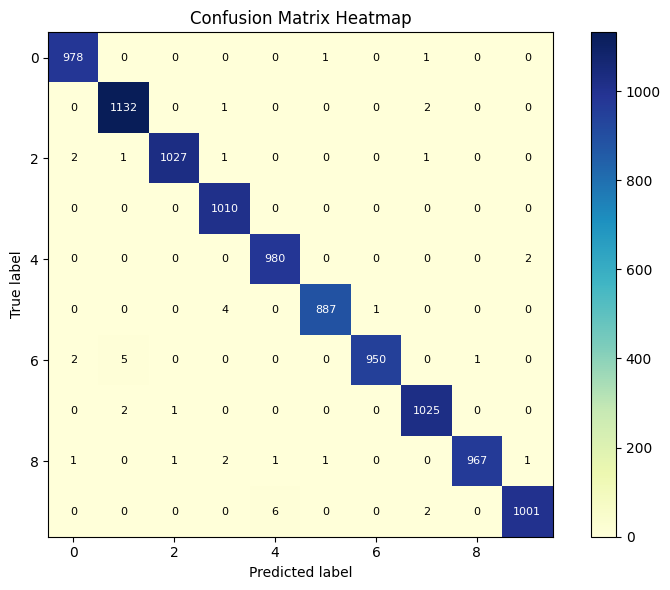

In [19]:
# 11. Confusion Matrix & Classification Report
y_pred_proba = model.predict(test_gen)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = y_test  # original integer labels

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='YlGnBu')
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()

for i in range(10):
    for j in range(10):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 color='white' if cm[i, j] > cm.max() / 2 else 'black',
                 fontsize=8)

plt.tight_layout()
plt.show()

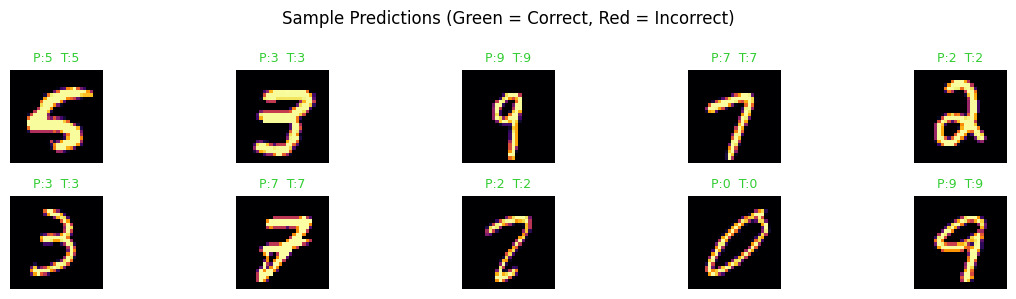

In [20]:
# 12. Sample Predictions – with Correct/Incorrect Colors
num_show = 10
indices = np.random.choice(len(x_test), num_show, replace=False)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='inferno')
    correct = (y_pred[idx] == y_true[idx])
    title_color = 'limegreen' if correct else 'red'
    plt.title(f"P:{y_pred[idx]}  T:{y_true[idx]}", color=title_color, fontsize=9)
    plt.axis('off')
plt.suptitle("Sample Predictions (Green = Correct, Red = Incorrect)", fontsize=12)
plt.tight_layout()
plt.show()


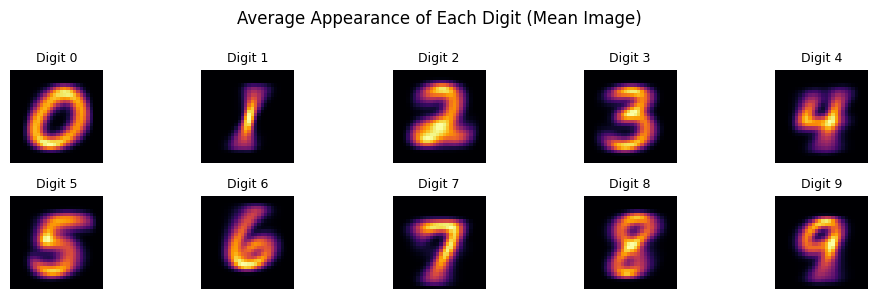

In [24]:
#13. Average Digit Appearance
avg_digits = np.zeros((10,28,28))

for digit in range(10):
    avg_digits[digit] = x_train[y_train == digit].mean(axis=0).reshape(28,28)

plt.figure(figsize=(10,3))
for d in range(10):
    plt.subplot(2,5,d+1)
    plt.imshow(avg_digits[d], cmap='inferno')
    plt.title(f"Digit {d}", fontsize=9)
    plt.axis('off')
plt.suptitle("Average Appearance of Each Digit (Mean Image)", fontsize=12)
plt.tight_layout()
plt.show()

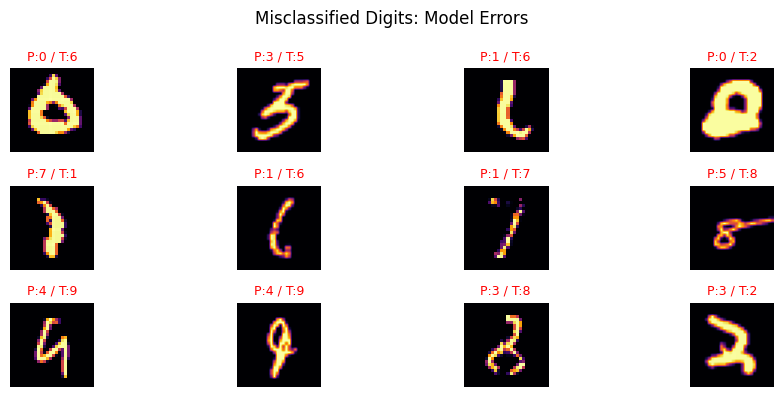

In [25]:
#14. Misclassified Digits
incorrect_indices = np.where(y_pred != y_true)[0]
sample_wrong = np.random.choice(incorrect_indices, size=12, replace=False)

plt.figure(figsize=(10,4))
for i, idx in enumerate(sample_wrong):
    plt.subplot(3,4,i+1)
    plt.imshow(x_test[idx].reshape(28,28), cmap='inferno')
    plt.title(f"P:{y_pred[idx]} / T:{y_true[idx]}", color='red', fontsize=9)
    plt.axis('off')
plt.suptitle("Misclassified Digits: Model Errors", fontsize=12)
plt.tight_layout()
plt.show()

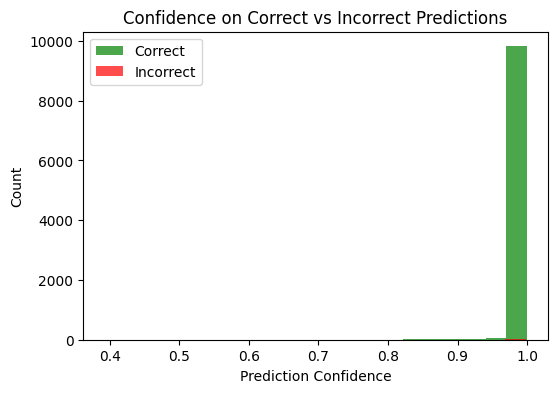

In [27]:
#15. Confidence vs Correctness
correct_conf = confidence[y_pred == y_true]
wrong_conf   = confidence[y_pred != y_true]

plt.figure(figsize=(6,4))
plt.hist(correct_conf, bins=20, alpha=0.7, label='Correct', color='green')
plt.hist(wrong_conf,   bins=20, alpha=0.7, label='Incorrect', color='red')
plt.xlabel("Prediction Confidence")
plt.ylabel("Count")
plt.title("Confidence on Correct vs Incorrect Predictions")
plt.legend()
plt.show()

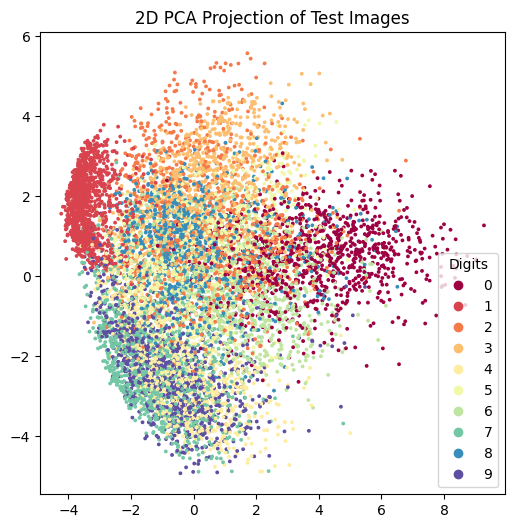

In [29]:
#16. PCA projection (2D embedding)
from sklearn.decomposition import PCA

X_flat = x_test.reshape(len(x_test), -1)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_flat)

plt.figure(figsize=(6,6))
scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y_test, cmap='Spectral', s=3)
plt.legend(*scatter.legend_elements(), title="Digits")
plt.title("2D PCA Projection of Test Images")
plt.show()